## Example: Poisson



$$
\begin{aligned}
   \qquad  \nabla u & = −2  sin(t) cos(x), \quad (t,x) \in [-2,2] \times [-2,2] \\
   u(t, −2) & = sin(t) cos(−2) &\quad u(−2, x) = sin(−2) cos(x)                \quad &&\quad t \in [-2,2],\\
   u(t, 2) &= sin(t)  cos( 2)& \quad  u( 2, x) = sin( 2) cos(x)                     \quad &&\quad x \in [-2,2].
\end{aligned}
$$



$$L_{\Omega}(\theta,\psi) = \frac{1}{|R|}\sum_{(\hat{t},\hat{x})\in R} Z(\hat{t},\hat{x})((\partial_x)^2P(\hat{t},\hat{x}) + (\partial_y)^2P(\hat{t},\hat{x}) +  2sin(\hat{t})cos(\hat{x})) \\
L_{\partial\Omega}(\theta,\psi) 
= \frac{1}{|\partial R|}\sum_{(t,x)\in \partial R} Z(t,x)( P(t,x) - g(t,x))$$

$((\partial_x)^2 + (\partial_y)^2)[P(\hat{t},\hat{x})] +  2sin(\hat{x})cos(\hat{t})$

In [ ]:
$((\partial_x)^2 + (\partial_x)^2)[P(\hat{t}^i,\hat{x}^i)]$

In [12]:
import sys
sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
'from plotting import newfig, savefig'
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from keras import models 

In [13]:
zz = tf.keras.models.Model

In [14]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
import scipy
zzz =tf.keras.models
zz = tf.keras.models.Model
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)


generate trainingset

In [15]:


from utils import trainingData
RNG_key = 3


lb = np.array([-2, -2])
ub = np.array([2, 2])

num_bc = 50
num_f= 5000

u = lambda xy: np.sin(xy[:, 0]) * np.cos([xy[:, 1]]) 
f = lambda x, y: -2 * np.sin(x) * np.cos(y)
all_xy_train, xy_bc, u_bc, xy_inside, f_xy = trainingData(lb, ub, num_bc, num_f, u, f, RNG_key)

# u_test_method = lambda x, y: np.sin(x) * np.cos(y) #takes 2 inputs, but should return same values as previous u
# x_test, y_test, xy_test, u_test, f_test, X, Y, U = testingData(lb, ub, u_test_method, f, 256)

In [16]:
#   xy_bc[:,[0]], xy_bc[:,[1]], u_bc, 
#                                 f_xy, xy_inside[:,[0]], xy_inside[:,[1]], RNG_key)
# xy_bc[:,0:1],xy_bc[:,1:2]

In [17]:
X_r = tf.constant(xy_inside,tf.float32)
X_data = [tf.constant(xy_bc,tf.float32)]
u_data =[ tf.constant(u_bc,tf.float32)] #boundary function values

In [18]:

# X_r[:,0:1],X_r[:,1:2]

(-2.0, 2.0)

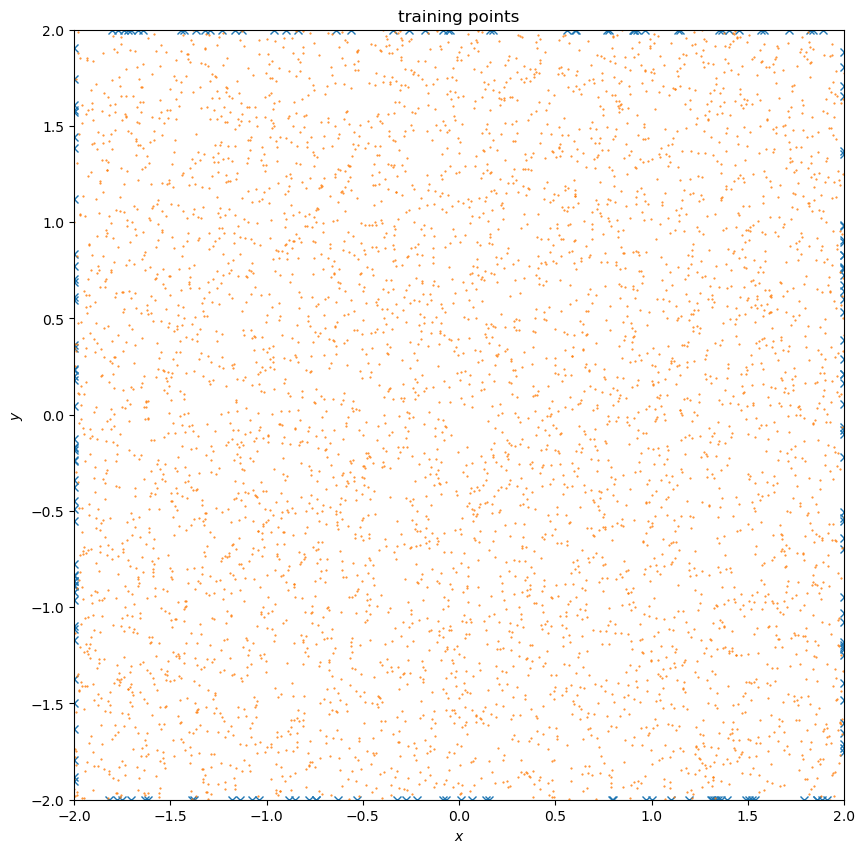

In [19]:
#plt.figure((10,10))
_,ax = plt.subplots(1,figsize=(10,10)) 
ax.plot(xy_bc[:,0:1],xy_bc[:,1:2], 'x', linewidth = 1)
plt.title('training points')  
#plt.plot(X_u_train[:,1], X_u_train[:,0], '*', color = 'red', markersize = 5, label = 'Boundary collocation = 100')
plt.plot(X_r[:,0:1],X_r[:,1:2], 'o', markersize = 0.5, label = 'PDE collocation = 5 000')

# ax = plt.subplot(gs1[0, 0])
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.axis('square')
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])

network for f  <br>
network for u

In [20]:
def res(x,y,u_x2,u_y2):#−2  sin(x) cos(y),
    return -2 * tf.sin(x) * tf.cos(y) - u_x2 - u_y2
@tf.function

 
def get_r(zz, X_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        x, y = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_x and u_y
        tape.watch(x)
        tape.watch(y)

        # Determine residual 
        u = zz(tf.stack([x[:,0], y[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_y = tape.gradient(u, y)
        u_y2 = tape.gradient(u_y, y)
        
        u_x = tape.gradient(u, x)
        u_x2 = tape.gradient(u_x, x)
            

    del tape

    return res(x,y,u_x2,u_y2)



In [21]:
# def U_x(zz,X_r):
#         with tf.GradientTape(persistent=True) as tape:
#         # Split t and x to compute partial derivatives
#             t, x = X_r[:, 0:1], X_r[:,1:2]

#             # Variables t and x are watched during tape
#             # to compute derivatives u_t and u_x
#             tape.watch(t)
#             tape.watch(x)
#             u = zz(tf.stack([t[:,0], x[:,0]], axis=1))
#             u_x = tape.gradient(u, x)
#         return u_x
    


The collocation points are given by `X_r`, the initial and boundary data is contained in `X_data = [X_0, X_b]` and `u_data = [u_0, u_b]`.

In [22]:
def compute_loss(zz, X_r, X_data, u_data):
    
    # Compute phi^r
    r = get_r(zz, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    
    # Initialize loss
    loss = phi_r
    
    # for i in range(len(X_data)):
    #     u_pred = zz(X_data[i]) # u(x,2) 
    #     loss += tf.reduce_mean(tf.square(u_data[i] - u_pred)) #  u(x,2)  - 2*sin(x)cos(2)
        
    u_pred = zz(X_data[0]) # u(x,2) 
    loss += tf.reduce_mean(tf.square(u_data[0] - u_pred))

    
    return loss

initialize the neuralnetwork

In [23]:

#kernel_initializer='glorot_normal'

def NN_manual():        

       z1 = zzz.Sequential([
        tf.keras.Input(shape=(2,)),
        tf.keras.layers.Dense(50,activation='tanh'),
        tf.keras.layers.Dense(50,activation='tanh'),
        tf.keras.layers.Dense(50,activation='tanh'),
        tf.keras.layers.Dense( 1, activation='tanh')
       ])
       return z1

def initialize_NN( ebenen):        
       components = []

       c0 = tf.keras.Input(shape=(ebenen[0],))
       components.append(c0)  
       num_ebenen = len(ebenen) 
       for l in range(1,num_ebenen - 1):
              c =  tf.keras.layers.Dense( (ebenen[l]), activation='tanh')
              components.append(c) 
              
       c =  tf.keras.layers.Dense( (ebenen[-1]), activation='linear')
       components.append(c)       
       return components

def neural_net(components):
       
       I = components[0]
       num_ebenen =  len(components)
       for l in range(1,num_ebenen -1):
              I = components[l](I)
       
       output_tensor = components[(num_ebenen-1)](I)
       return zz(components[0],output_tensor)



In [24]:
layers = np.array([2,50 ,50, 50,1]) 

In [25]:
nn = neural_net(initialize_NN(layers))

In [26]:
nn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,301 (20.71 KB)

 Trainable params: 5,301 (20.71 KB)

 Non-trainable params: 0 (0.00 B)

initial loss

In [27]:
compute_loss(nn, X_r, X_data, u_data)

<tf.Tensor: shape=(), dtype=float32, numpy=1.5705808401107788>

The next function computes the gradient of the loss function $L_\theta$ with respect to the parameters zz, also called `trainable_variables` in TensorFlow, i.e. $\nabla_\theta \phi_\theta$.
This is also done via a `GradientTape`, but now it keeps track of the parameters $\theta$ in our zz, which can be accessed by `zz.trainable_variables`.

In [28]:
#  nn.trainable_variables

In [29]:
def get_grad(zz, X_r, X_data, u_data):
    
    with tf.GradientTape(persistent=True) as tape:
        #tape.watch(zz.trainable_variables)
        loss = compute_loss(zz, X_r, X_data, u_data)

    g = tape.gradient(loss, zz.trainable_variables)
    del tape

    return loss, g


$$
\delta(n) = 0.01 \, \textbf{1}_{\{n < 1000\}} + 0.001 \, \textbf{1}_{\{1000 \le n < 3000\}} + 0.0005 \, \textbf{1}_{\{3000 \le n\}}
$$


In [30]:
# Initialize zz aka u_\theta
# NN = NN_manual(
    
# )
components = initialize_NN([2,50,50,50,1])
NN = neural_net(components)
# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [31]:
loss, grad_theta = get_grad(nn, X_r, X_data, u_data)

In [32]:
10**5

100000

Train the network for $N=10**5$ epochs (10**5forward passes)
 set up a function `train_step()` 



In [33]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(nn, X_r, X_data, u_data)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, nn.trainable_variables))
    
    return loss

# Number of training epochs

N = 10 ** 5
train_loss_record = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist
    
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        train_loss_record.append(loss)
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.57058084e+00
It 00050: loss = 1.66308403e-01


KeyboardInterrupt: 

In [34]:
# nn.save_weights("D:\ARBEIT\pinn\PINNs\poisson\weights\_.weights.h5")

In [35]:
NN.load_weights("poisson.weights.h5")

In [36]:
from utils import testingData

In [37]:

def testingData(lb, ub, u, f, num):


  X=np.linspace(lb[0], ub[0], num)
  Y=np.linspace(lb[1], ub[1], num)
    
  X, Y = np.meshgrid(X,Y) #X, Y are (256, 256) matrices

  U = u(X,Y)
  u_test = U.flatten('F')[:,None]
  xy_test = np.hstack((X.flatten('F')[:,None], Y.flatten('F')[:,None]))
  x_test = xy_test[:,[0]]
  y_test = xy_test[:,[1]]
  
  f_test = f(xy_test[:,[0]], xy_test[:,[1]])
  # f_test = torch.from_numpy(f_test).to(device)

  # x_test = torch.from_numpy(xy_test[:,[0]]).to(device)
  # y_test = torch.from_numpy(xy_test[:,[1]]).to(device)
#   f_test = f(x_test, y_test)
  return x_test, y_test, xy_test, u_test, f_test, X, Y, U

In [38]:
u_test_method = lambda x, y: np.sin(x) * np.cos(y) #takes 2 inputs, but should return same values as previous u
x_test, y_test, xy_test, u_test, f_test, X, Y, U = testingData(lb, ub, u_test_method, f, 256)


In [39]:
u_test = u_test_method(x_test,y_test)

In [40]:
def test():

    
    u_pred = NN(xy_test)
    
    
    error_vec = np.linalg.norm(( u_test- u_pred),2) / np.linalg.norm( u_test, 2)  # Relative L2 Norm of the error (Vector)

    return error_vec#, u_pred

$L_2$  relative norm

$\| PINN(x,y) -  u(x,y) \|_2$

In [41]:
test()

0.007793986723930779

In [42]:
import pandas as pd
train_loss_record = pd.read_csv("train_loss_record2_2.csv").values

In [43]:
train_loss_record

array([[4.36857e-01],
       [2.45816e-01],
       [1.72765e-01],
       ...,
       [4.90000e-05],
       [3.88000e-04],
       [4.90000e-05]])

In [44]:
# nn.save_weights("poisson.weights.h5")
# #np.savetxt('/kaggle/working/l3.csv', l3, fmt='%f')

# np.savetxt('train_loss_record2.csv', train_loss_record, fmt='%f')

In [45]:
300 * (15* 2 + 2)

9600

In [46]:
train_loss_record.__len__() * 50

100000

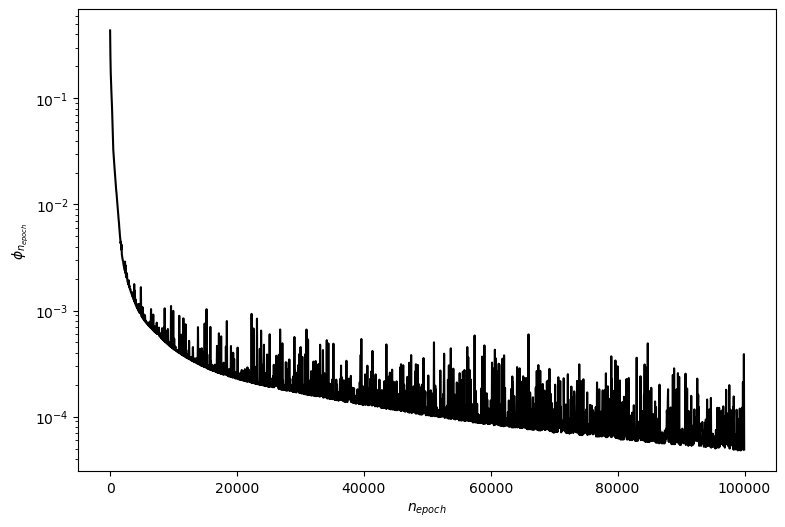

<Figure size 900x600 with 0 Axes>

In [47]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy([k *50 for k in range(len(train_loss_record))], train_loss_record,'k-')
ax.set_xlabel('$n_{epoch} $')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
fig = plt.figure(figsize=(9,6))
# ax = fig.add_subplot(111)
# ax.semilogy([i*(50 * (12* 2 + 2)) for i in range(len(hist))], hist,'k-')
# ax.set_xlabel('$n_{epoch}$')
# ax.set_ylabel('$\\phi_{n_{epoch}}$');
# ax = fig.add_subplot(111)
# ax.plot(range(len(train_loss_record)), train_loss_record,'k-')
# ax.set_xlabel('$n_{epoch}$')

In [85]:
tf.keras.layers.Dense(1,activation='linear')

<Dense name=dense_14, built=False>

In [49]:
def sol(X_r):
    x, y = X_r[:, 0:1], X_r[:,1:2]
    return np.sin(x) * np.cos(y)

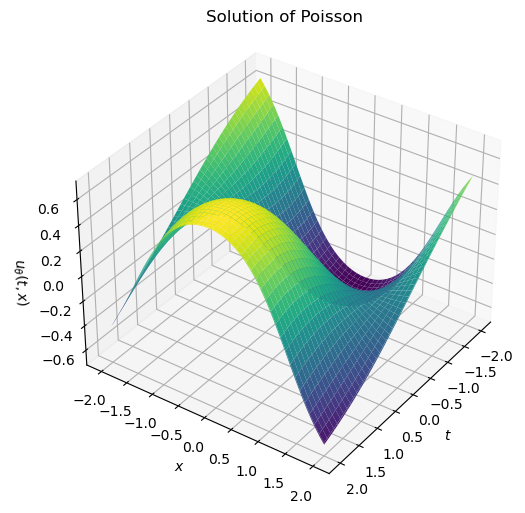

In [81]:
from mpl_toolkits.mplot3d import Axes3D
#takes 2 inputs, but should return same values as previous u
# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = nn(tf.cast(Xgrid,DTYPE))
sol1   =    sol(tf.cast(Xgrid,DTYPE))
R = sol1.reshape(N+1,N+1)
# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis');
#ax.plot_surface(T, X, R)
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Poisson');


In [1]:
import pandas as pd

In [2]:
path = "D:\\ARBEIT\\pinn\\CPINN\\Poisson\\Poisson\\results (1)\\Poisson\\output\\1_dis_GACGD_tol_1e-07_atol_1e-20_g_iter_10\\ACGDInfo_1999.csv"
z_1 = pd.read_csv(path)


In [69]:
hist    =z_1.loc[z_1["iter_num_sum"] <  10**5]

In [9]:
174648 / 10**4

17.4648

In [12]:
a = z_1["iter_num_sum"][1999] + 4 * 2000

In [14]:
a - 10**5

82648

In [15]:
import pandas as pd
z_1 = pd.read_csv("D:\\ARBEIT\\pinn\\CPINN\\Poisson\\Poisson\\output\\1_dis_GACGD_tol_1e-07_atol_1e-20_g_iter_1000\\history\\ACGDInfo_1576.csv")
hist =  hist['PINN loss']
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy([i*(50 * (15* 2 + 2)) for i in range(len(hist))], hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');

NameError: name 'hist' is not defined

In [65]:
# fig = plt.figure(figsize=(9,6))
# ax = fig.add_subplot(111)
# ax.semilogy(range(len(train_loss_record)), train_loss_record,'k-')
# ax.set_xlabel('$n_{epoch}$')
# ax.set_ylabel('$\\phi_{n_{epoch}}$');
# ax.semilogy([i*(50 * (15* 2 + 2)) for i in range(len(hist))], hist,'k-')
# ax.set_xlabel('$n_{epoch}$')
# ax.set_ylabel('$\\phi_{n_{epoch}}$');

### Plot solution